In [49]:
import pandas as pd
import re
import numpy as np
import random
import openai
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
# Load the dataset
file_path = '3026NMfixed_UT.csv'
data = pd.read_csv(file_path)

In [51]:
# Function to clean text; combines all parts of an utterance
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()

In [52]:
# Apply the cleaning function to the utterances
data['cleaned_utterance'] = data['utterance'].apply(clean_text)

In [53]:
# Combine Speaker and cleaned utterance columns for better context
data['text'] = data['Speaker'].astype(str) + ' ' + data['cleaned_utterance']

In [54]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text'])

# Encode labels (ut column)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['ut'])

In [55]:
# Function to build the neural network model
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
# Train and evaluate model over different training percentages
training_percentages = [0.2, 0.4, 0.6, 0.8]
results = []

for train_percentage in training_percentages:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_percentage, random_state=42)
    model = build_model(X.shape[1])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    results.append((train_percentage, score[1]))
    print(f"Training Percentage: {train_percentage * 100:.0f}%, Test Accuracy: {score[1] * 100:.2f}%")

Training Percentage: 20%, Test Accuracy: 28.10%
Training Percentage: 40%, Test Accuracy: 31.56%
Training Percentage: 60%, Test Accuracy: 41.15%
Training Percentage: 80%, Test Accuracy: 37.17%


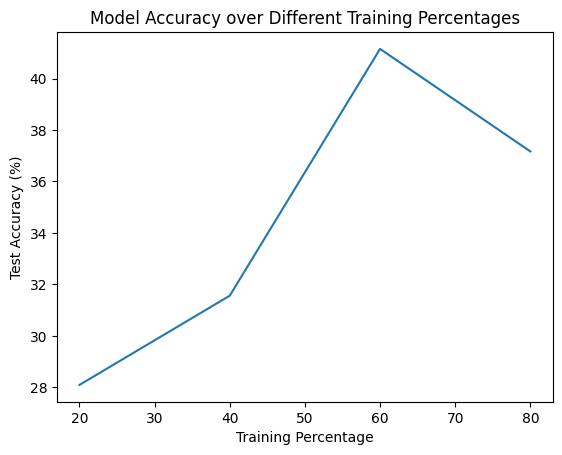

In [57]:
# Plot accuracy over different training percentages
train_percentages, accuracies = zip(*results)
plt.plot(np.array(train_percentages) * 100, np.array(accuracies) * 100)
plt.xlabel('Training Percentage')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Accuracy over Different Training Percentages')
plt.show()

In [58]:
# Display results in a DataFrame
results_df = pd.DataFrame(results, columns=['Training Percentage', 'Test Accuracy'])
print(results_df)

   Training Percentage  Test Accuracy
0                  0.2       0.280973
1                  0.4       0.315634
2                  0.6       0.411504
3                  0.8       0.371681


In [59]:
# Simulated Annealing for Classification
num_clusters = 16
max_iterations = 10
initial_temperature = 1.0
cooling_rate = 0.95
openai.api_key = ''
classification_cache = {}

def classify_utterances(utterances, speakers, use_cache=True):
    classifications = []
    not_cached_utterances, not_cached_speakers, not_cached_indices = [], [], []
    missing_classifications = 0

    for idx, (utterance, speaker) in enumerate(zip(utterances, speakers)):
        if use_cache and utterance in classification_cache:
            classifications.append(classification_cache[utterance])
        else:
            not_cached_utterances.append(utterance)
            not_cached_speakers.append(speaker)
            not_cached_indices.append(idx)

    if not_cached_utterances:
        batch_prompt = f"""Classify the following utterances based on the provided coding scheme and the following rules:
        1. When the speaker is 'S' the possible classifications are Ry, Rs, and Rq.
        2. When the speaker is 'T' the classifications of Ry, Rs, and Rq are not possible.

        Coding Scheme:
        For Teacher (T):
        • Q - Question: An inquiry posed to the student. Example: “Can you explain the water cycle?”
        • P - Prompt: A cue aimed to guide the student’s response or thought process. Example: “Think about the plant in sunlight.”
        • E - Example/Explanation: Offering detailed information or illustrating a concept. Example: “Photosynthesis is when plants convert sunlight into energy.”
        • F - Feedback: Providing input on a student's statement or answer.
          1) Fy - Confirmatory Feedback: Affirming the correctness of a student’s answer or repeating students’ responses. Example: “That's right!” 
          2) Fs - Feedback with Statements: Providing feedback with additional information. Example: “Yes, and it also involves carbon dioxide.”
          3) Fq - Feedback with a Question: Giving feedback and further probing the student. Example: “Correct. Now, what's its role in the food chain?”
        • NA – Inaudible or Meaningless: Any utterance that is unclear or unrelated.

        For Student (S):
        • R - Response: Replies to teacher's questions or prompts.
          1) Ry - Confirmatory responses: Agreement or acknowledgment. Example: “Yes, I understand.” 
          2) Rs - Response with statement: Providing an answer or viewpoint. Example: “Photosynthesis is a plant’s way of creating energy.”
          3) Rq – Response with a question: Further inquiry based on the discussion. Example: “But why do plants need sunlight specifically?”
        • NA – Inaudible or meaningless: Cannot be discerned or lacks educational relevance.

        Utterances: {json.dumps(list(zip(not_cached_indices, not_cached_speakers, not_cached_utterances)))}

        Return the classifications in the following format:
        index: classification
        """

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": batch_prompt}
            ]
        )

        response_text = response['choices'][0]['message']['content'].strip()
        responses = [line.strip() for line in response_text.split('\n') if line.strip()]

        parsed_responses = {}
        for line in responses:
            try:
                idx, classification = line.split(': ', 1)
                parsed_responses[int(idx)] = classification.strip()
            except ValueError as e:
                print(f"Error parsing line: {line}\nException: {e}")

        for i, idx in enumerate(not_cached_indices):
            if idx in parsed_responses:
                classification = parsed_responses[idx]
                speaker = not_cached_speakers[i]
                if speaker == 'S' and classification not in ['Ry', 'Rs', 'Rq']:
                    classification = 'NA'
                elif speaker == 'T' and classification in ['Ry', 'Rs', 'Rq']:
                    classification = 'NA'
                classifications.append(classification)
                classification_cache[not_cached_utterances[i]] = classification
            else:
                classifications.append('NA')  # Handle missing classifications with a default value
                missing_classifications += 1
                print(f"Warning: Missing classification for utterance index {idx}")

    return classifications, missing_classifications

In [60]:
# Test the batch classification function
example_utterances = data['cleaned_utterance'].iloc[:10].tolist()
example_speakers = data['Speaker'].iloc[:10].tolist()
classify_utterances(example_utterances, example_speakers)

(['Q', 'P', 'NA', 'Q', 'NA', 'NA', 'Ry', 'Q', 'Rs', 'E'], 0)

In [61]:
def fitness_function(individual):
    utterances = [data['cleaned_utterance'].iloc[idx] for idx in range(len(individual))]
    speakers = [data['Speaker'].iloc[idx] for idx in range(len(individual))]
    classifications, missing_classifications = classify_utterances(utterances, speakers, use_cache=False)  # Disable cache for fitness evaluation
    
    # Calculate fitness based on the consistency and quality of classifications
    fitness = calculate_fitness(classifications)
    return fitness, missing_classifications

In [62]:
def calculate_fitness(classifications):
    # Example fitness function based on the number of correct classifications
    correct_count = sum([1 for c in classifications if c in data['ut'].values])
    return correct_count / len(classifications)

In [63]:
def random_neighbor(individual, num_clusters):
    neighbor = individual.copy()
    idx = random.randint(0, len(individual) - 1)
    neighbor[idx] = random.randint(0, num_clusters - 1)
    return neighbor

In [64]:
def simulated_annealing(initial_solution, num_clusters, max_iterations, initial_temperature, cooling_rate):
    current_solution = initial_solution
    current_fitness, current_missing_classifications = fitness_function(current_solution)
    best_solution = current_solution
    best_fitness = current_fitness
    total_missing_classifications = current_missing_classifications
    temperature = initial_temperature
    performance_scores = []
    
    for iteration in range(max_iterations):
        neighbor = random_neighbor(current_solution, num_clusters)
        neighbor_fitness, neighbor_missing_classifications = fitness_function(neighbor)
        
        if neighbor_fitness > current_fitness or random.uniform(0, 1) < np.exp((neighbor_fitness - current_fitness) / temperature):
            current_solution = neighbor
            current_fitness = neighbor_fitness
            current_missing_classifications = neighbor_missing_classifications
        
        if current_fitness > best_fitness:
            best_solution = current_solution
            best_fitness = current_fitness
        
        performance_scores.append(best_fitness)
        total_missing_classifications += current_missing_classifications
        temperature *= cooling_rate
        print(f"Iteration {iteration + 1}, Fitness: {current_fitness}, Best Fitness: {best_fitness}")

    average_missing_classifications = total_missing_classifications / max_iterations
    return best_solution, performance_scores, average_missing_classifications

In [65]:
# Initialize solution randomly
initial_solution = np.random.randint(0, num_clusters, size=data.shape[0])

In [66]:
# Run the simulated annealing algorithm
best_solution, performance_scores, average_missing_classifications = simulated_annealing(initial_solution, num_clusters, max_iterations, initial_temperature, cooling_rate)

Iteration 1, Fitness: 0.06548672566371681, Best Fitness: 0.41238938053097346
Iteration 2, Fitness: 0.647787610619469, Best Fitness: 0.647787610619469
Iteration 3, Fitness: 0.6, Best Fitness: 0.647787610619469
Iteration 4, Fitness: 0.6, Best Fitness: 0.647787610619469
Iteration 5, Fitness: 0.5327433628318584, Best Fitness: 0.647787610619469
Iteration 6, Fitness: 0.03716814159292035, Best Fitness: 0.647787610619469
Error parsing line: [[0, "Q"], [1, "P"], [2, "NA"], [3, "Fq"], [4, "Rs"], [5, "Rq"], [6, "Ry"], [7, "Q"], [8, "Rs"], [9, "E"], [10, "Q"], [11, "Rs"], [12, "E"], [13, "Rs"], [14, "E"], [15, "E"], [16, "E"], [17, "Fy"], [18, "E"], [19, "Rs"], [20, "Rs"], [21, "Fq"], [22, "Q"], [23, "Ry"], [24, "E"], [25, "E"], [26, "E"], [27, "Rs"], [28, "Fy"], [29, "Rs"], [30, "Rs"], [31, "E"], [32, "Q"], [33, "Q"], [34, "Q"], [35, "Q"], [36, "Q"], [37, "Rs"], [38, "NA"], [39, "Rs"], [40, "Fy"], [41, "Rs"], [42, "Ry"], [43, "E"], [44, "E"], [45, "E"], [46, "E"], [47, "E"], [48, "E"], [49, "E"],

In [67]:
# Classify utterances based on the best solution
data['classified_code'] = [classify_utterances([data['cleaned_utterance'].iloc[idx]], [data['Speaker'].iloc[idx]])[0] for idx in range(data.shape[0])]

In [68]:
# Save the results
data.to_csv('3026NMfixed_UT_classified.csv', index=False)

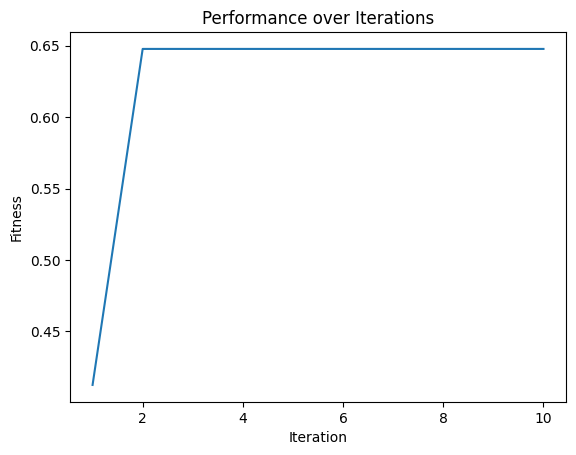

In [69]:
# Generate a performance graph
plt.plot(range(1, max_iterations + 1), performance_scores)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Performance over Iterations')
plt.show()

In [70]:
# Create a table of parameters and their values
parameters = {
    "Max Iterations": max_iterations,
    "Initial Temperature": initial_temperature,
    "Cooling Rate": cooling_rate,
    "Number of Clusters": num_clusters,
    "Best Fitness Score": max(performance_scores),
    "Average Missing Classifications": average_missing_classifications
}

parameters_df = pd.DataFrame(list(parameters.items()), columns=['Parameter', 'Value'])
print(parameters_df)

                         Parameter       Value
0                   Max Iterations   10.000000
1              Initial Temperature    1.000000
2                     Cooling Rate    0.950000
3               Number of Clusters   16.000000
4               Best Fitness Score    0.647788
5  Average Missing Classifications  214.000000
